In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from CASutils import averaging_utils as avg
from CASutils import qbo_utils as qbo
from CASutils import plotposition_utils as plotpos
from CASutils import readdata_utils as read
from CASutils import colorbar_utils as cbars
from CASutils import filter_utils as filt
from CASutils import plothisto_utils as histo
from CASutils import colormap_utils as mycolors

import sys

In [5]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/SUPP/"

In [8]:
def maketransition_composites(u_tropics, dat, nlag):
    
    #---composite code
    def dothecomposite_a(dat, ewloc, nlag):
        lagarr = np.arange(0,nlag)
        for icomp in np.arange(0,len(ewloc),1):
            datuse = dat.isel(time=slice(int(ewloc[icomp]), int(ewloc[icomp]) + nlag))
            datuse['time'] = lagarr
            if (icomp == 0):
                datcomp = datuse/len(ewloc)
            else:
                datcomp = datcomp + datuse / len(ewloc)
        return datcomp
    
    def dothecomposite_b(dat, ewloc, nlag):
        lagarr = np.arange(0,nlag)
        for icomp in np.arange(0,len(ewloc),1):
            datuse = dat.isel(time=slice(int(ewloc[icomp])-nlag, int(ewloc[icomp])))
            datuse['time'] = lagarr
            if (icomp == 0):
                datcomp = datuse/len(ewloc)
            else:
                datcomp = datcomp + datuse / len(ewloc)
        return datcomp
    
    comp_u=[]
    comp_divf=[]
    uzm = u_tropics
    u30d = filt.runningmean(uzm, 30, dropna=False)
    ewloc, weloc = qbo.finde2w(u30d)
    ewloc_a = ewloc[ (ewloc > 0) & (ewloc < (uzm.time.size - nlag)) ]
    ewloc_b = ewloc[ (ewloc > nlag) & (ewloc < uzm.time.size) ] 
    print(ewloc_a)
    print(ewloc_b)
    
    comp_u_b = dothecomposite_b(dat.uzm, ewloc_b, nlag)
    comp_divf_b = dothecomposite_b(dat.utendepfd, ewloc_b, nlag)
    
    comp_u_a = dothecomposite_a(dat.uzm, ewloc_a, nlag)
    comp_divf_a = dothecomposite_a(dat.utendepfd, ewloc_a, nlag)
    
    comp_u_b = comp_u_b.rename('uzm')
    comp_u_a = comp_u_a.rename('uzm')
    comp_divf_b = comp_divf_b.rename('divf')
    comp_divf_a = comp_divf_a.rename('divf')
    
    datout_b = xr.merge([comp_u_b, comp_divf_b])
    datout_a = xr.merge([comp_u_a, comp_divf_a])
    
    return datout_b, datout_a

In [9]:
nlags = 90 # the number of days to composite over

w=5
era5 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/day/ERA5.nc")
era5 = era5.rename(plev='ilev')
era5['ilev'] = era5.ilev/100.
era5 = era5.where( (era5.ilev < 110) & (era5.ilev > 7), drop=True)
u_tropics = avg.cosweightlat(era5.uzm, -1.*w, w).interp(ilev=50.)

era5_b, era5_a = maketransition_composites(u_tropics, era5, nlags)

dz=['800','700','600','500']
alldat_b=[] ; alldat_a=[]
for i in np.arange(0,len(dz),1):
    basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/day/"
    dat = xr.open_dataset(basepath+'dz'+dz[i]+'_80km.nc')
    
    u_tropics = avg.cosweightlat(dat.uzm, -1.*w, w).interp(ilev=50.)
    dat = dat.where( (dat.ilev < 110) & (dat.ilev > 5), drop=True)
    
    datout_b, datout_a = maketransition_composites(u_tropics, dat, nlags)
    
    alldat_b.append(datout_b) ; alldat_a.append(datout_a)

DataArrayWeighted with weights along dimensions: lat
[  518.  1388.  2284.  3201.  4150.  5095.  5855.  6688.  7387.  8474.
  9241. 10014. 10735. 11589. 12576. 13372. 13778. 14664. 15217. 15962.]
[  518.  1388.  2284.  3201.  4150.  5095.  5855.  6688.  7387.  8474.
  9241. 10014. 10735. 11589. 12576. 13372. 13778. 14664. 15217. 15962.]
DataArrayWeighted with weights along dimensions: lat
[ 498. 1210. 1935. 2679. 3419. 4190. 4818. 5595. 6433.]
[ 498. 1210. 1935. 2679. 3419. 4190. 4818. 5595. 6433.]
DataArrayWeighted with weights along dimensions: lat
[ 502. 1228. 1957. 2656. 3398. 4146. 4770. 5681. 6521.]
[ 502. 1228. 1957. 2656. 3398. 4146. 4770. 5681. 6521. 7247.]
DataArrayWeighted with weights along dimensions: lat
[ 522. 1295. 2176. 2926. 3612. 4309. 4862. 5932. 6542.]
[ 522. 1295. 2176. 2926. 3612. 4309. 4862. 5932. 6542.]
DataArrayWeighted with weights along dimensions: lat
[ 894. 2100. 2881. 3813. 4756. 5963. 7089.]
[ 894. 2100. 2881. 3813. 4756. 5963. 7089.]


In [10]:
def plotlatpre(fig, dat, titlestr, ci, cmin, cmax, x1, x2, y1, y2, ylabels=False):
    
    nlevs = (cmax - cmin)/ci + 1
    clevs = np.arange(cmin, cmax+ci, ci)
    mymap = mycolors.blue2red_cmap(nlevs)
    ax = fig.add_axes([x1,y1,x2-x1,y2-y1])
    ax.contourf(dat.lat, -np.log10(dat.ilev), dat, levels=clevs, cmap=mymap, extend='both')
    ax.set_ylim(-np.log10(110),-np.log10(10))
    ax.set_yticks([-np.log10(100),-np.log10(70),-np.log10(50),-np.log10(30),-np.log10(20),-np.log10(10)])
    ax.set_title(titlestr, fontsize=16)
    if (ylabels):
        ax.set_yticklabels(['100','70','50','30','20','10'], fontsize=14)
        ax.set_ylabel('Pressure (hPa)', fontsize=14)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '], fontsize=14)
    ax.set_xlim(-15,15)
    ax.set_xticks([-10,0,10])
    ax.set_xticklabels(['-10','0','10'], fontsize=14)
    ax.set_xlabel('Latitude', fontsize=14)
    
    return ax

In [11]:
x1=[0.13,0.25,0.37,0.49,0.61,0.73,0.85]
x2=[0.24,0.36,0.48,0.6,0.72,0.84,0.96]

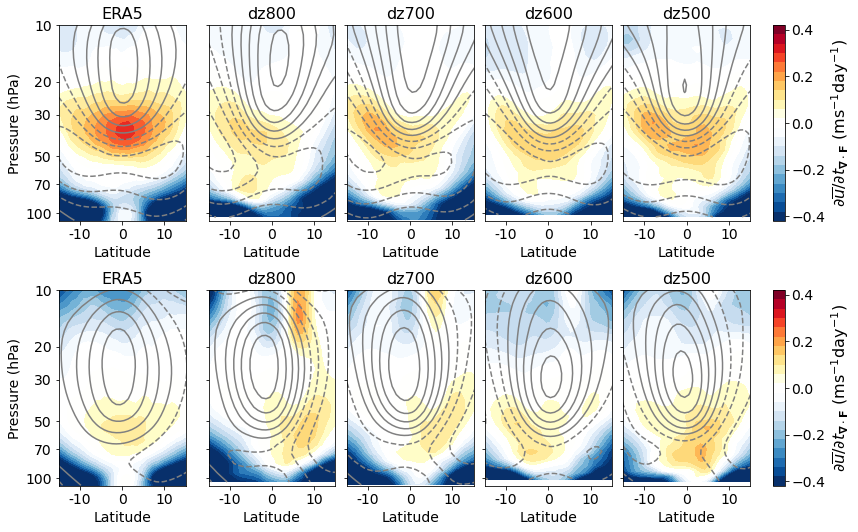

In [12]:
fig = plt.figure(figsize=(16,16))

ci=4 ; cmax=20 ; cmin=-20

ax = plotlatpre(fig, era5_b.divf.mean('time')*86400.,'ERA5',0.04,-0.4,0.4,0,0.11,0.8,0.97, ylabels=True)
clevs = np.arange(cmin, cmax+ci, ci)
ax.contour(era5_b.lat, -np.log10(era5_b.ilev), era5_b.uzm.mean('time'), levels=clevs, colors='gray')

for i in np.arange(0,len(dz),1):
    ax = plotlatpre(fig, alldat_b[i].divf.mean('time')*86400.,'dz'+dz[i],0.04,-0.4,0.4,x1[i],x2[i],0.8,0.97)
    clevs = np.arange(cmin,cmax+ci, ci) #; clevs = clevs[np.abs(clevs) > ci]
    ax.contour(alldat_b[i].lat, -np.log10(alldat_b[i].ilev), alldat_b[i].uzm.mean('time'),
               levels=clevs, colors='gray')
    
ax = cbars.plotcolorbar(fig, 0.04,-0.4,0.4,r'$\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$ (ms$^{-1}$day$^{-1}$)',
                        0.62,0.63,0.8,0.97, orient='vertical')
    
ax = plotlatpre(fig, era5_a.divf.mean('time')*86400.,'ERA5',0.04,-0.4,0.4,0,0.11,0.57,0.74, ylabels=True)
clevs = np.arange(cmin, cmax+ci, ci)
ax.contour(era5_a.lat, -np.log10(era5_a.ilev), era5_a.uzm.mean('time'), levels=clevs, colors='gray')

for i in np.arange(0,len(dz),1):
    ax = plotlatpre(fig, alldat_a[i].divf.mean('time')*86400.,'dz'+dz[i],0.04,-0.4,0.4,x1[i],x2[i],0.57,0.74)
    clevs = np.arange(cmin,cmax+ci, ci) #; clevs = clevs[np.abs(clevs) > ci]
    ax.contour(alldat_a[i].lat, -np.log10(alldat_a[i].ilev), alldat_a[i].uzm.mean('time'),
               levels=clevs, colors='gray')
    
ax = cbars.plotcolorbar(fig, 0.04,-0.4,0.4,r'$\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$ (ms$^{-1}$day$^{-1}$)',
                        0.62,0.63,0.57,0.74, orient='vertical')

fig.savefig(plotpath+'figS7.pdf', bbox_inches='tight', facecolor='white')